In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, classification_report



In [4]:
train_data = pd.read_csv('nepal_train.csv', delimiter=';')
train_labels = pd.read_csv('nepal_train_labels.csv', delimiter=';')



The data is loaded into a DataFrame named train_data, which will contain the feature values for the Nepal earthquake dataset.

In [5]:
train_data.head()


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,739427,13,257,8352,3,25,2,5,n,r,...,0,0,0,0,0,0,0,0,0,2
1,17201,6,1076,9202,3,40,10,8,o,r,...,0,1,0,0,0,0,0,0,0,2
2,723805,7,838,10723,2,45,8,5,t,r,...,0,0,0,0,0,0,0,0,0,3
3,891512,7,555,2763,2,30,7,4,t,r,...,0,0,0,0,0,0,0,0,0,2
4,484350,17,682,1039,3,30,6,7,t,r,...,0,0,0,0,0,0,0,0,0,3


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208480 entries, 0 to 208479
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             208480 non-null  int64 
 1   geo_level_1_id                          208480 non-null  int64 
 2   geo_level_2_id                          208480 non-null  int64 
 3   geo_level_3_id                          208480 non-null  int64 
 4   count_floors_pre_eq                     208480 non-null  int64 
 5   age                                     208480 non-null  int64 
 6   area_percentage                         208480 non-null  int64 
 7   height_percentage                       208480 non-null  int64 
 8   land_surface_condition                  208480 non-null  object
 9   foundation_type                         208480 non-null  object
 10  roof_type                               208480 non-null 

In [7]:
train_data.shape

(208480, 40)

The dataset consists of 208,480 entries and 40 features, with no missing values

In [8]:
train_labels.head()

,building_id,damage_grade
0,739427,2
1,17201,2
2,723805,3
3,891512,2
4,484350,3


In [9]:
train_labels.shape

(208480, 2)

The dataset consists of 208,480 entries and 2 features, with no missing values

In [10]:
data = train_data.merge(train_labels, on='building_id')

In [11]:
data = data.drop(columns=['damage_grade_x']).rename(columns={'damage_grade_y': 'damage_grade'})



During the merge, both train_data and train_labels contained a damage_grade column, pandas would suffix these with _x and _y to distinguish them. Dropping damage_grade_x helps keep only the target column we want (damage_grade_y).

In [12]:
data['damage_binary'] = data['damage_grade'].apply(lambda x: 1 if x == 3 else 0)



I created a new binary column, damage_binary, to represent whether a building has severe damage (damage_grade 3) or not (damage grade 1 or 2). 

In [13]:
# Display data types and summary statistics
data_info = data.info()
data_head = data.head()
data_description = data.describe(include='all')



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208480 entries, 0 to 208479
Data columns (total 41 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             208480 non-null  int64 
 1   geo_level_1_id                          208480 non-null  int64 
 2   geo_level_2_id                          208480 non-null  int64 
 3   geo_level_3_id                          208480 non-null  int64 
 4   count_floors_pre_eq                     208480 non-null  int64 
 5   age                                     208480 non-null  int64 
 6   area_percentage                         208480 non-null  int64 
 7   height_percentage                       208480 non-null  int64 
 8   land_surface_condition                  208480 non-null  object
 9   foundation_type                         208480 non-null  object
 10  roof_type                               208480 non-null 

In [14]:
# Checking the distribution of the binary damage target
damage_binary_distribution = data['damage_binary'].value_counts(normalize=True)

# Output results
data_info, data_head, data_description, damage_binary_distribution

(None,
    building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
 0       739427              13             257            8352   
 1        17201               6            1076            9202   
 2       723805               7             838           10723   
 3       891512               7             555            2763   
 4       484350              17             682            1039   
 
    count_floors_pre_eq  age  area_percentage  height_percentage  \
 0                    3   25                2                  5   
 1                    3   40               10                  8   
 2                    2   45                8                  5   
 3                    2   30                7                  4   
 4                    3   30                6                  7   
 
   land_surface_condition foundation_type  ... has_secondary_use_rental  \
 0                      n               r  ...                        0   
 1                      o    

After converting the damage_grade to a binary damage_binary, i see that 66.5% of buildings are labeled as 'Low/Moderate Damage' (0), and 33.5% as 'High Damage' (1).

In [15]:
# Encoding categorical variables
data_encoded = pd.get_dummies(data, columns=[
    'land_surface_condition', 'foundation_type', 'roof_type', 
    'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 
    'legal_ownership_status'
])

# Checking the data structure after encoding
data_encoded_info = data_encoded.info()
data_encoded.head(), data_encoded_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208480 entries, 0 to 208479
Data columns (total 71 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   building_id                             208480 non-null  int64
 1   geo_level_1_id                          208480 non-null  int64
 2   geo_level_2_id                          208480 non-null  int64
 3   geo_level_3_id                          208480 non-null  int64
 4   count_floors_pre_eq                     208480 non-null  int64
 5   age                                     208480 non-null  int64
 6   area_percentage                         208480 non-null  int64
 7   height_percentage                       208480 non-null  int64
 8   has_superstructure_adobe_mud            208480 non-null  int64
 9   has_superstructure_mud_mortar_stone     208480 non-null  int64
 10  has_superstructure_stone_flag           208480 non-null  int64
 11  

(   building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
 0       739427              13             257            8352   
 1        17201               6            1076            9202   
 2       723805               7             838           10723   
 3       891512               7             555            2763   
 4       484350              17             682            1039   
 
    count_floors_pre_eq  age  area_percentage  height_percentage  \
 0                    3   25                2                  5   
 1                    3   40               10                  8   
 2                    2   45                8                  5   
 3                    2   30                7                  4   
 4                    3   30                6                  7   
 
    has_superstructure_adobe_mud  has_superstructure_mud_mortar_stone  ...  \
 0                             1                                    0  ...   
 1                            

one-hot encoding to convert categorical variables into numerical form, making the dataset compatible with machine learning models that require numerical inputs

In [16]:
X = data_encoded.drop(columns=['building_id', 'damage_grade', 'damage_binary'])
y = data_encoded['damage_binary']

building_id is an identifier that doesn’t carry predictive value, so it is dropped.
damage_grade is the original multi-class target, which has been replaced by damage_binary.
damage_binary (the binary target column) is also removed here, as it will be used as the target vector y.

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



20% of the data will be allocated to the validation set, and the remaining 80% will go to the training set

In [18]:
# Train a Logistic Regression model as a baseline
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

/Users/november/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [19]:
# Evaluate model using cross-validation and compute ROC AUC
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
mean_cv_auc = np.mean(cv_scores)



/Users/november/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/november/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

logistic regression model did not converge, meaning it was unable to find optimal values for the model parameters within the specified number of iterations

In [20]:
# Predict probabilities for validation data
y_val_probs = model.predict_proba(X_val)[:, 1]

# Calculate ROC and PR curves
fpr, tpr, _ = roc_curve(y_val, y_val_probs)
precision, recall, _ = precision_recall_curve(y_val, y_val_probs)

# Store the model's AUC score and initial curves data
mean_cv_auc, fpr, tpr, precision, recall

(np.float64(0.6747642737459557),
 array([0.00000000e+00, 0.00000000e+00, 3.60425302e-05, ...,
        9.97621193e-01, 9.97621193e-01, 1.00000000e+00]),
 array([0.00000000e+00, 7.16794495e-05, 7.16794495e-05, ...,
        9.99928321e-01, 1.00000000e+00, 1.00000000e+00]),
 array([0.33458845, 0.33459647, 0.3346045 , ..., 0.5       , 1.        ,
        1.        ]),
 array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        7.16794495e-05, 7.16794495e-05, 0.00000000e+00]))

np.float64(0.6747642737459557) : This is the AUC (Area Under the ROC Curve) score
An AUC of 0.675 indicates that the model performs moderately well at distinguishing between the two classes

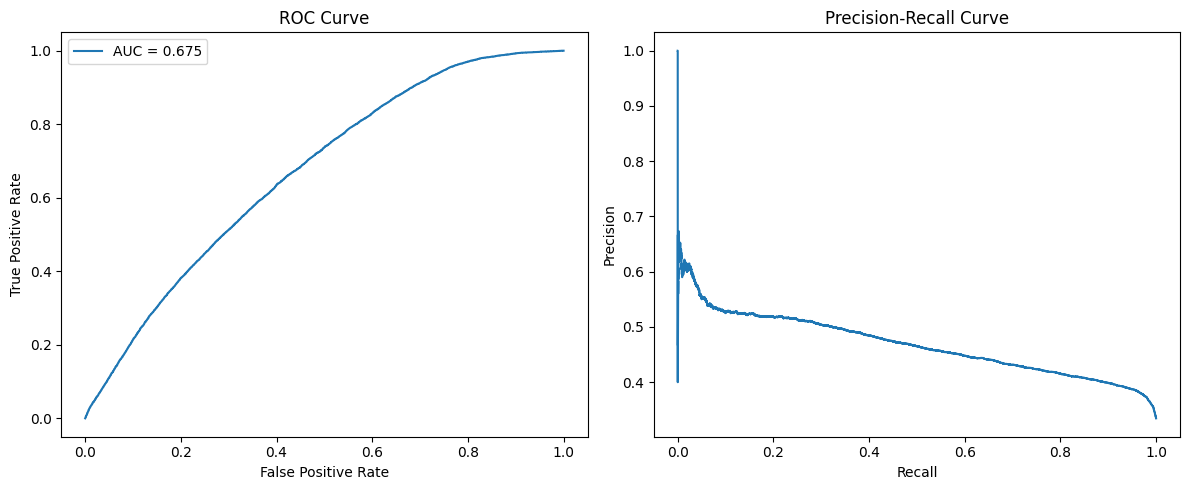

In [21]:
import matplotlib.pyplot as plt

# Plot ROC Curve
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {mean_cv_auc:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()


the trade-offs between sensitivity (recall) and precision, as well as overall model discriminative ability (ROC)

The ROC Curve shows a steady increase in the True Positive Rate (TPR) as the False Positive Rate (FPR) increases.

In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)  
X_reduced = selector.fit_transform(X)

X_train_red, X_val_red, y_train_red, y_val_red = train_test_split(X_reduced, y, test_size=0.2, random_state=42, stratify=y)

model_reduced = LogisticRegression(max_iter=1000, random_state=42)
model_reduced.fit(X_train_red, y_train_red)

cv_scores_red = cross_val_score(model_reduced, X_train_red, y_train_red, cv=5, scoring='roc_auc')
mean_cv_auc_red = np.mean(cv_scores_red)

y_val_probs_red = model_reduced.predict_proba(X_val_red)[:, 1]

fpr_red, tpr_red, _ = roc_curve(y_val_red, y_val_probs_red)
precision_red, recall_red, _ = precision_recall_curve(y_val_red, y_val_probs_red)

mean_cv_auc_red, fpr_red, tpr_red, precision_red, recall_red

/Users/november/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/november/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

(np.float64(0.6744175759426458),
 array([0.        , 0.        , 0.        , ..., 0.99754911, 0.99754911,
        1.        ]),
 array([0.00000000e+00, 7.16794495e-05, 1.43358899e-04, ...,
        9.99928321e-01, 1.00000000e+00, 1.00000000e+00]),
 array([0.33458845, 0.33459647, 0.3346045 , ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.43358899e-04, 7.16794495e-05, 0.00000000e+00]))

AUC score (Area Under the Curve for the Receiver Operating Characteristic)
A value of around 0.67 is modest, indicating the model has some ability to discriminate between classes, but there’s room for improvement (values closer to 1 indicate stronger performance).

The modest AUC score suggests a need for further tuning or possibly a more complex model to improve performance.

Comparison to Original Model
AUC Scores: The AUC score barely changed after feature selection, indicating that the removed low-variance features were not significantly impacting performance.
ROC and PR Curves: Based on these similar metrics, the shape of the ROC and PR curves should be almost identical to the original curves, suggesting no substantial improvement or degradation from feature selection.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, precision_recall_curve


X = data_encoded.drop(columns=['building_id', 'damage_grade', 'damage_binary'])
y = data_encoded['damage_binary']


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


pca = PCA(n_components=0.95)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)


model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_pca, y_train)

cv_scores = cross_val_score(model, X_train_pca, y_train, cv=5, scoring='roc_auc')
mean_cv_auc = np.mean(cv_scores)

y_val_probs = model.predict_proba(X_val_pca)[:, 1]

fpr, tpr, _ = roc_curve(y_val, y_val_probs)
precision, recall, _ = precision_recall_curve(y_val, y_val_probs)

print("Mean Cross-Validation AUC:", mean_cv_auc)
print("PCA Components Used:", pca.n_components_)


Mean Cross-Validation AUC: 0.6739355051922225
PCA Components Used: 50


uses scaling and PCA to reduce dimensionality, trains a logistic regression model, and evaluates it on the validation set

The AUC scores across different methods are similar, indicating that neither feature selection nor PCA significantly impacts the model’s ability to distinguish between classes.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # Regularization strength values

grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train_pca, y_train)

best_model = grid_search.best_estimator_
best_auc = grid_search.best_score_

print("Best Cross-Validation AUC:", best_auc)
print("Best Parameters:", grid_search.best_params_)


Best Cross-Validation AUC: 0.6739386925002073
Best Parameters: {'C': 0.01}


The best cross-validation AUC score is 0.6739, which is very close to the previous AUC scores obtained with the default C value.

adjusting the regularization parameter had a minimal effect on the model's performance, likely because logistic regression’s predictive power has reached its limit on this dataset.

The grid search did not significantly improve the AUC, confirming that logistic regression may not be able to capture additional patterns in the data.

hyperparameter tuning provided only a very slight improvement in AUC, suggesting that Logistic Regression may not be capturing the complexity of this dataset.


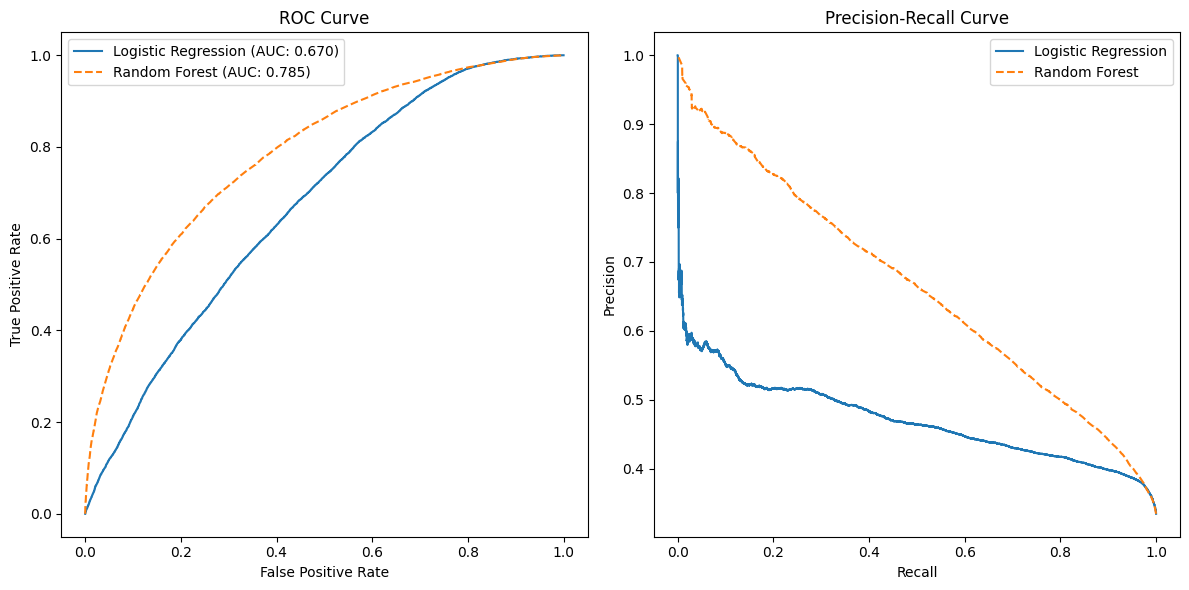

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Train a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_pca, y_train)

# Predict probabilities for validation data
y_val_probs_rf = rf_model.predict_proba(X_val_pca)[:, 1]

# Calculate AUC for both models
lr_auc = roc_auc_score(y_val, y_val_probs)
rf_auc = roc_auc_score(y_val, y_val_probs_rf)

# ROC and PR Curves for both models
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_val_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_val_probs_rf)
precision_lr, recall_lr, _ = precision_recall_curve(y_val, y_val_probs)
precision_rf, recall_rf, _ = precision_recall_curve(y_val, y_val_probs_rf)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC: {lr_auc:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC: {rf_auc:.3f})', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall_lr, precision_lr, label='Logistic Regression')
plt.plot(recall_rf, precision_rf, label='Random Forest', linestyle='--')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()


The rf_auc for Random Forest and lr_auc for Logistic Regression allow direct comparison of the two models.

The Random Forest model has a significantly higher AUC (0.785) compared to Logistic Regression (0.670). This indicates that the Random Forest model is better at distinguishing between the two classes.

The Random Forest ROC curve is closer to the top-left corner, which is ideal, as it indicates a higher true positive rate (TPR) for a given false positive rate (FPR).

The Logistic Regression ROC curve is consistently below the Random Forest curve, confirming that Logistic Regression is less effective in distinguishing between the classes.

In [ ]:
from sklearn.metrics import average_precision_score, f1_score

ap_lr = average_precision_score(y_val, y_val_probs)
ap_rf = average_precision_score(y_val, y_val_probs_rf)

# Compute F1-Score at the 0.5 threshold
f1_lr = f1_score(y_val, y_val_probs > 0.5)
f1_rf = f1_score(y_val, y_val_probs_rf > 0.5)

print("Logistic Regression - Average Precision (AP):", ap_lr)
print("Logistic Regression - F1 Score:", f1_lr)
print("Random Forest - Average Precision (AP):", ap_rf)
print("Random Forest - F1 Score:", f1_rf)

if f1_rf > f1_lr and ap_rf > ap_lr:
    best_model = rf_model
    best_model_name = "Random Forest"
    best_model_score = f1_rf
else:
    best_model = model
    best_model_name = "Logistic Regression"
    best_model_score = f1_lr

print(f"Best Model: {best_model_name} with F1 Score: {best_model_score:.3f}")


Logistic Regression - Average Precision (AP): 0.4710225023426592
Logistic Regression - F1 Score: 0.18809707470480033
Random Forest - Average Precision (AP): 0.6612071619762221
Random Forest - F1 Score: 0.5693742553104072
Best Model: Random Forest with F1 Score: 0.569


Random Forest has significantly higher AP and F1 scores than Logistic Regression, indicating it performs better at balancing precision and recall and maintaining higher precision across recall levels.

Given the higher scores for Random Forest, it is chosen as the best model. The F1 Score of 0.569 indicates a reasonably balanced performance in terms of precision and recall.

In [27]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Predictions for validation data
y_val_pred_lr = (y_val_probs >= 0.5).astype(int)  # Threshold for Logistic Regression
y_val_pred_rf = (y_val_probs_rf >= 0.5).astype(int)  # Threshold for Random Forest

# Calculate scores for Logistic Regression
lr_accuracy = accuracy_score(y_val, y_val_pred_lr)
lr_f1 = f1_score(y_val, y_val_pred_lr)
lr_precision = precision_score(y_val, y_val_pred_lr)
lr_recall = recall_score(y_val, y_val_pred_lr)

# Calculate scores for Random Forest
rf_accuracy = accuracy_score(y_val, y_val_pred_rf)
rf_f1 = f1_score(y_val, y_val_pred_rf)
rf_precision = precision_score(y_val, y_val_pred_rf)
rf_recall = recall_score(y_val, y_val_pred_rf)

# Print detailed classification reports for both models
print("Logistic Regression Classification Report:")
print(classification_report(y_val, y_val_pred_lr))

print("\nRandom Forest Classification Report:")
print(classification_report(y_val, y_val_pred_rf))

# Display summary of key metrics
print("\nSummary of Key Metrics:")
print(f"Logistic Regression - Accuracy: {lr_accuracy:.3f}, F1: {lr_f1:.3f}, Precision: {lr_precision:.3f}, Recall: {lr_recall:.3f}")
print(f"Random Forest       - Accuracy: {rf_accuracy:.3f}, F1: {rf_f1:.3f}, Precision: {rf_precision:.3f}, Recall: {rf_recall:.3f}")


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.95      0.79     27745
           1       0.55      0.11      0.19     13951

    accuracy                           0.67     41696
   macro avg       0.61      0.53      0.49     41696
weighted avg       0.64      0.67      0.59     41696


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82     27745
           1       0.66      0.51      0.57     13951

    accuracy                           0.75     41696
   macro avg       0.72      0.69      0.70     41696
weighted avg       0.74      0.75      0.74     41696


Summary of Key Metrics:
Logistic Regression - Accuracy: 0.672, F1: 0.188, Precision: 0.546, Recall: 0.114
Random Forest       - Accuracy: 0.748, F1: 0.573, Precision: 0.661, Recall: 0.505


Imbalance in Recall: Logistic Regression has a high recall for class 0 (0.95) but a very low recall for class 1 (0.11), indicating that it misses many severe damage cases (class 1).

Poor F1 for Class 1: The F1-score for class 1 is low (0.19), which highlights that the model struggles to balance precision and recall for the minority class (severe damage).

Summary

Random Forest Outperforms Logistic Regression: In all key metrics (accuracy, F1, precision, and recall), Random Forest shows superior performance, particularly for identifying the minority class (severe damage).

Balanced Performance: Random Forest provides a better balance between capturing true positives and minimizing false positives, which is crucial for handling imbalanced data like this.